# Predictive Modeling of Customer Bookings
## Complete ML Pipeline with Deployment Ready Code

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load data
df = pd.read_csv("C:/Users/knigh/Downloads/Compressed/Flight_booking_pred-main/Flight_booking_pred-main/customer_booking (1).csv", encoding="ISO-8859-1")

## 2. Exploratory Data Analysis & Data Cleaning

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memor

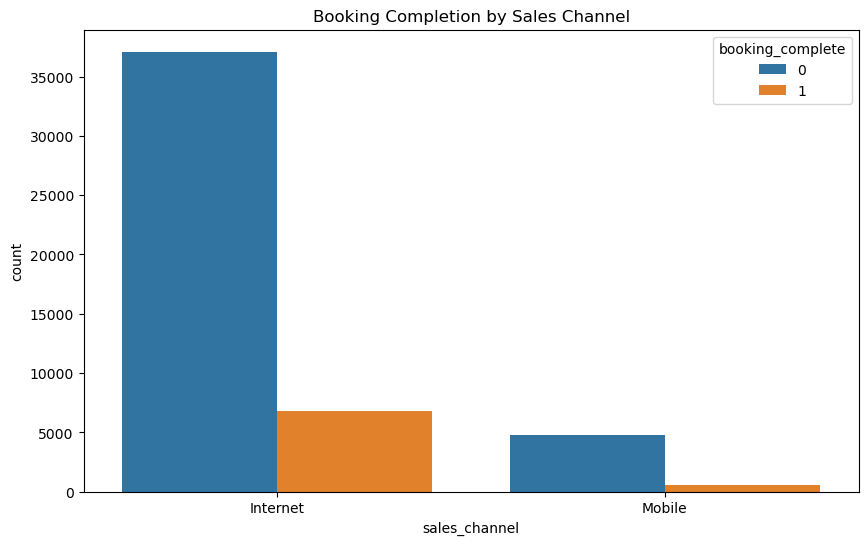


Class distribution:
booking_complete
0    41890
1     7391
Name: count, dtype: int64
Class ratio (0:1): 5.67


In [2]:
print("Dataset Info:")
df.info()

print("\nFirst 5 rows:")
df.head()

print("\nDataset Description:")
df.describe()

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Convert flight_day to numerical
mapping = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}
df["flight_day"] = df["flight_day"].map(mapping)

# Drop route column as it's high cardinality
df = df.drop('route', axis=1)

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.title('Booking Completion by Sales Channel')
plt.show()

# Check class imbalance
print(f"\nClass distribution:\n{df['booking_complete'].value_counts()}")
print(f"Class ratio (0:1): {sum(df['booking_complete'] == 0) / sum(df['booking_complete'] == 1):.2f}")

## 3. Advanced Preprocessing Pipeline

In [3]:
# Define features and target
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# Split data BEFORE any preprocessing to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define column types
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 
                  'flight_hour', 'flight_day', 'flight_duration']
categorical_cols = ['sales_channel', 'trip_type']
high_cardinality_cols = ['booking_origin']
binary_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('high_card', OneHotEncoder(max_categories=10, handle_unknown='infrequent_if_exist'), high_cardinality_cols)
], remainder='passthrough')  # binary columns passed through as-is

print("Preprocessing pipeline created successfully!")

Preprocessing pipeline created successfully!


## 4. Model Training with Cross-Validation

In [4]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{'='*50}")
    print(f"{model_name} Evaluation")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc')
    print(f"CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, y_proba

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# XGBoost Pipeline
class_ratio = sum(y_train == 0) / sum(y_train == 1)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=class_ratio
    ))
])

# Train models
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)

# Evaluate models
rf_pred, rf_proba = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
xgb_pred, xgb_proba = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost")

Training Random Forest...
Training XGBoost...

Random Forest Evaluation
Accuracy: 0.8356
ROC AUC: 0.7246
F1 Score: 0.2377
CV ROC AUC: 0.7140 (+/- 0.0131)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12568
           1       0.39      0.17      0.24      2217

    accuracy                           0.84     14785
   macro avg       0.63      0.56      0.57     14785
weighted avg       0.80      0.84      0.81     14785


XGBoost Evaluation
Accuracy: 0.6908
ROC AUC: 0.7373
F1 Score: 0.3909
CV ROC AUC: 0.7073 (+/- 0.0273)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79     12568
           1       0.28      0.66      0.39      2217

    accuracy                           0.69     14785
   macro avg       0.60      0.68      0.59     14785
weighted avg       0.82      0.69      0.73     14785



## 5. Model Comparison & Feature Importance

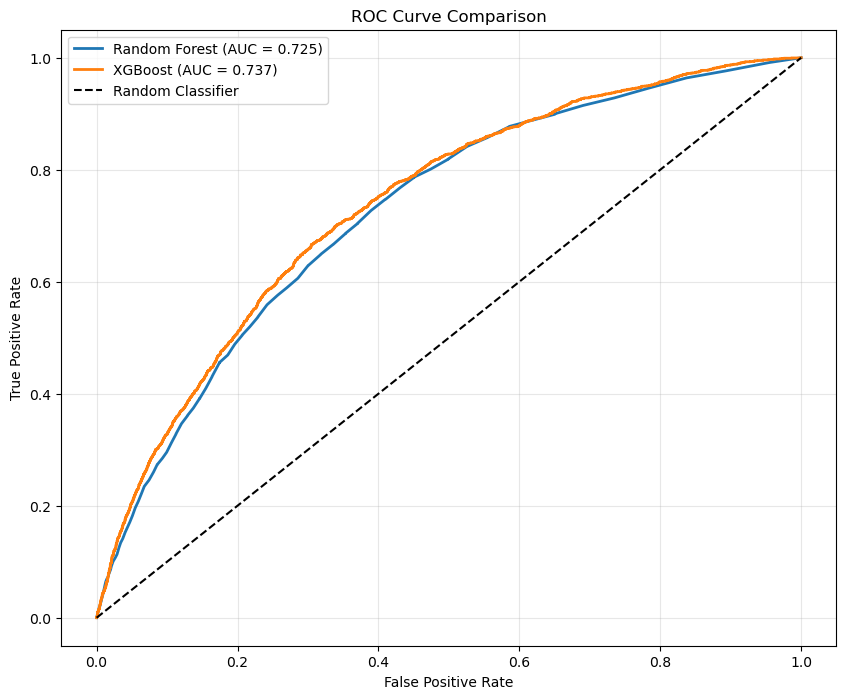


Model Comparison:
           Model  Accuracy  ROC AUC  F1 Score
0  Random Forest    0.8356   0.7246    0.2377
1        XGBoost    0.6908   0.7373    0.3909

Random Forest Feature Importance:


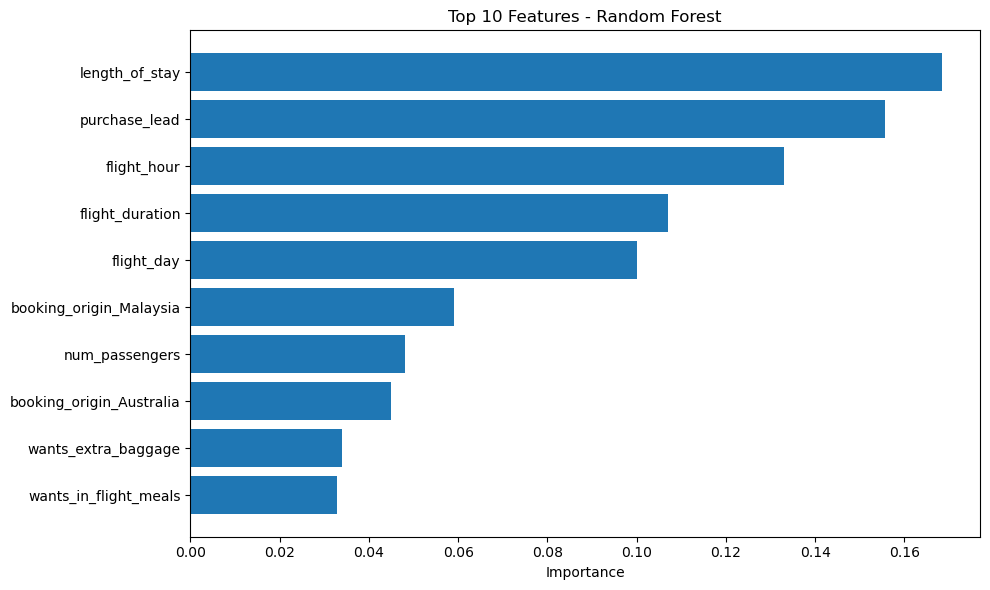


XGBoost Feature Importance:


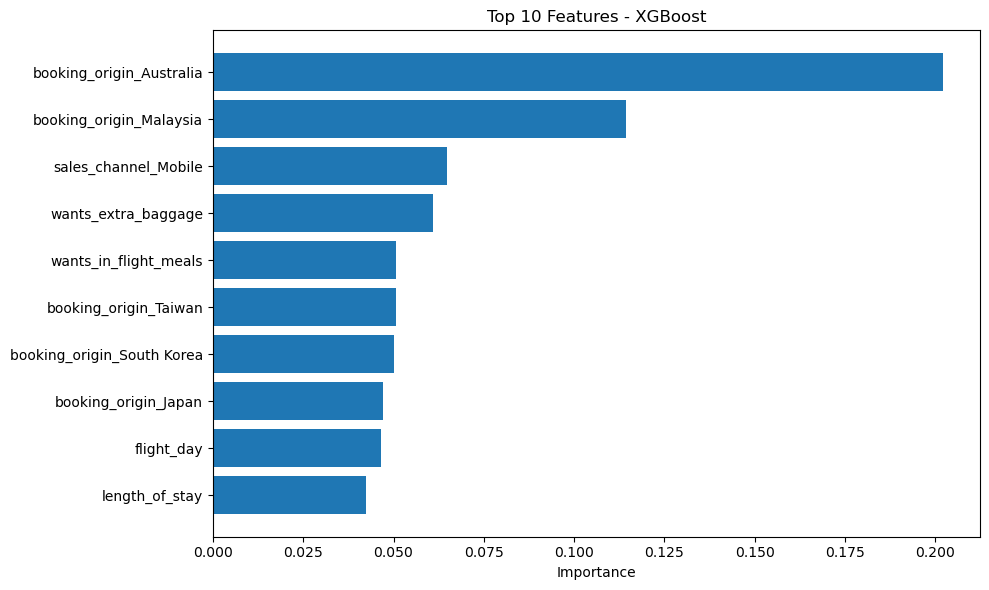

In [5]:
# ROC Curve Comparison
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Metrics Comparison
metrics_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'ROC AUC': [rf_auc, xgb_auc],
    'F1 Score': [
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred)
    ]
})

print("\nModel Comparison:")
print(metrics_comparison.round(4))

# Feature Importance
feature_names = (
    numerical_cols + 
    list(rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)) +
    list(rf_pipeline.named_steps['preprocessor'].named_transformers_['high_card'].get_feature_names_out(high_cardinality_cols)) +
    binary_cols
)

rf_importance = rf_pipeline.named_steps['classifier'].feature_importances_
xgb_importance = xgb_pipeline.named_steps['classifier'].feature_importances_

# Plot top features
def plot_top_features(importance, feature_names, model_name, top_n=10):
    feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_imp = feature_imp.sort_values('importance', ascending=True).tail(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp['feature'], feature_imp['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

print("\nRandom Forest Feature Importance:")
rf_top_features = plot_top_features(rf_importance, feature_names, "Random Forest")

print("\nXGBoost Feature Importance:")
xgb_top_features = plot_top_features(xgb_importance, feature_names, "XGBoost")

## 6. Model Deployment Preparation

In [6]:
# Save the best model (XGBoost based on ROC AUC)
best_model = xgb_pipeline

with open('booking_predictor.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature names and column transformers for deployment
deployment_artifacts = {
    'feature_names': feature_names,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'high_cardinality_cols': high_cardinality_cols,
    'binary_cols': binary_cols,
    'model_metrics': {
        'accuracy': float(accuracy_score(y_test, xgb_pred)),
        'roc_auc': float(xgb_auc),
        'f1_score': float(f1_score(y_test, xgb_pred))
    }
}

with open('deployment_artifacts.json', 'w') as f:
    json.dump(deployment_artifacts, f, indent=2)

print("✅ Model and artifacts saved successfully!")
print(f"📊 Model Performance:")
print(f"   - Accuracy: {deployment_artifacts['model_metrics']['accuracy']:.4f}")
print(f"   - ROC AUC: {deployment_artifacts['model_metrics']['roc_auc']:.4f}")
print(f"   - F1 Score: {deployment_artifacts['model_metrics']['f1_score']:.4f}")

✅ Model and artifacts saved successfully!
📊 Model Performance:
   - Accuracy: 0.6908
   - ROC AUC: 0.7373
   - F1 Score: 0.3909


## 7. Deployment Code - Streamlit Web App

In [7]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
import json

# Load model and artifacts
with open('booking_predictor.pkl', 'rb') as f:
    model = pickle.load(f)

with open('deployment_artifacts.json', 'r') as f:
    artifacts = json.load(f)

st.set_page_config(page_title="Flight Booking Predictor", page_icon="✈️")

st.title("✈️ Flight Booking Completion Predictor")
st.markdown("Predict whether a customer will complete their flight booking")

# Sidebar with model info
st.sidebar.header("Model Information")
st.sidebar.metric("Accuracy", f"{artifacts['model_metrics']['accuracy']:.1%}")
st.sidebar.metric("ROC AUC", f"{artifacts['model_metrics']['roc_auc']:.3f}")
st.sidebar.metric("F1 Score", f"{artifacts['model_metrics']['f1_score']:.3f}")

# Main input form
st.header("Booking Details")

col1, col2 = st.columns(2)

with col1:
    num_passengers = st.slider("Number of Passengers", 1, 10, 1)
    sales_channel = st.selectbox("Sales Channel", ["Internet", "Mobile"])
    trip_type = st.selectbox("Trip Type", ["RoundTrip", "OneWay", "CircleTrip"])
    purchase_lead = st.number_input("Purchase Lead (days)", min_value=0, max_value=365, value=30)
    length_of_stay = st.number_input("Length of Stay (days)", min_value=1, max_value=365, value=7)

with col2:
    flight_hour = st.slider("Flight Hour", 0, 23, 12)
    flight_day = st.selectbox("Flight Day", ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    booking_origin = st.selectbox("Booking Origin", ["Australia", "Malaysia", "China", "Japan", "UK", "US", "Germany"])
    flight_duration = st.number_input("Flight Duration (hours)", min_value=1.0, max_value=24.0, value=5.0)

# Additional preferences
st.subheader("Customer Preferences")
col3, col4, col5 = st.columns(3)
with col3:
    wants_extra_baggage = st.checkbox("Extra Baggage")
with col4:
    wants_preferred_seat = st.checkbox("Preferred Seat")
with col5:
    wants_in_flight_meals = st.checkbox("In-Flight Meals")

# Prepare input data
flight_day_mapping = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}

input_data = pd.DataFrame({
    'num_passengers': [num_passengers],
    'sales_channel': [sales_channel],
    'trip_type': [trip_type],
    'purchase_lead': [purchase_lead],
    'length_of_stay': [length_of_stay],
    'flight_hour': [flight_hour],
    'flight_day': [flight_day_mapping[flight_day]],
    'booking_origin': [booking_origin],
    'wants_extra_baggage': [1 if wants_extra_baggage else 0],
    'wants_preferred_seat': [1 if wants_preferred_seat else 0],
    'wants_in_flight_meals': [1 if wants_in_flight_meals else 0],
    'flight_duration': [flight_duration]
})

# Prediction
if st.button("Predict Booking Completion"):
    try:
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[0][1]
        
        st.header("Prediction Result")
        
        if prediction == 1:
            st.success(f"✅ High likelihood of booking completion ({probability:.1%} probability)")
        else:
            st.error(f"❌ Low likelihood of booking completion ({probability:.1%} probability)")
        
        # Show probability gauge
        st.subheader("Confidence Level")
        st.progress(float(probability))
        st.write(f"Confidence: {probability:.1%}")
        
        # Business recommendations
        st.subheader("Recommendations")
        if prediction == 0 and probability < 0.3:
            st.info("💡 Consider offering promotional discounts or flexible booking options")
        elif prediction == 0 and probability < 0.6:
            st.info("💡 Suggest adding travel insurance or highlighting popular routes")
        else:
            st.info("💡 Customer shows strong intent - focus on smooth checkout process")
            
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")

# Footer
st.markdown("---")
st.markdown("*Built with XGBoost • Model updated with latest booking data*")

Writing app.py
